In [1]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Distributions
using Interpolations
using Knet: Knet, dir, accuracy, progress, sgd, load143, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout,sigm # param, param0, xavier_uniform
using Knet
using Images
using Plots
using LinearAlgebra
using IterTools: ncycle, takenth
using MLDatasets
using Base.Iterators: flatten
import CUDA # functional
using ImageTransformations
using Statistics
using Memento
using NPZ
using PyPlot
using Random
# using Interpolations
atype=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})

┌ Warning: You are using Matplotlib 2.1.2, which is no longer
│ officialy supported by the Plots community. To ensure smooth Plots.jl
│ integration update your Matplotlib library to a version >= 3.4.0
│ 
│ If you have used Conda.jl to install PyPlot (default installation),
│ upgrade your matplotlib via Conda.jl and rebuild the PyPlot.
│ 
│ If you are not sure, here are the default instructions:
│ 
│ In Julia REPL:
│ ```
│ import Pkg;
│ Pkg.add("Conda")
│ import Conda
│ Conda.update()
│ Pkg.build("PyPlot")
│ ```
│ 
└ @ Plots /kuacc/users/bbozkurt15/.julia/packages/Plots/qbc7U/src/backends/pyplot.jl:29


KnetArray{Float32, N} where N

In [2]:
pwd()

"/scratch/users/bbozkurt15/MyJulia/GON_Project_Deployables/Evaluation_Notebook"

In [3]:
cd("..")

In [4]:
pwd()

"/scratch/users/bbozkurt15/MyJulia/GON_Project_Deployables"

In [5]:
const F = Float32
params = Knet.params

logger = Memento.config!("info"; fmt="[{date} | {level} | {name}]: {msg}");

include("PlotUtility.jl")
include("ImageUtility.jl")
include("TrainUtility.jl")
include("LayerUtility.jl")
include("LossUtility.jl")

using .PlotUtility
using .ImageUtility
using .TrainUtility
using .LayerUtility
using .LossUtility

In [6]:
use_saved_data = false
nc = nothing
dataset_name = "mnist"
if dataset_name == "mnist"
    nc = 1
    if use_saved_data
        xtrn = npzread("Data/MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))

    else

        xtrn,_ = MNIST.traindata()
        xtst,_ = MNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)
        
    end
    
elseif dataset_name == "fashion"
    nc = 1
    if use_saved_data

        xtrn = npzread("Data/Fashion_MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/Fashion_MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))
        
    else
        
        xtrn,_ = FashionMNIST.traindata()
        xtst,_ = FashionMNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)

    end
    
elseif dataset_name == "cifar"
    nc = 3
    xtrn,_= CIFAR10.traindata()
    xtst,_ = CIFAR10.testdata()
    xtrn = Array{Float64, 4}(xtrn)
    xtst = Array{Float64, 4}(xtst)
#     println("No implemented yet")
end

batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (32, 32, nc,:), xtype = atype, shuffle = true)
dtst = minibatch(xtst, batch_size; xsize = (32, 32, nc,:), xtype = atype);

# VAE GON MNIST - NGF : 16, NZ : 256

In [7]:
results_path = "./Results/Variational_GON_ngf16_nz256_mnist1"
model_path = joinpath(results_path, "Saved_Models")

"./Results/Variational_GON_ngf16_nz256_mnist1/Saved_Models"

In [8]:
readdir(results_path)

7-element Vector{String}:
 "Images"
 "Logger"
 "Saved_Models"
 "trn_loss_list.jld2"
 "trn_rec_loss_list.jld2"
 "tst_loss_list.jld2"
 "tst_rec_loss_list.jld2"

In [9]:
readdir(model_path)

10-element Vector{String}:
 "Model_VAEGON1100.jld2"
 "Model_VAEGON1200.jld2"
 "Model_VAEGON1300.jld2"
 "Model_VAEGON1400.jld2"
 "Model_VAEGON1500.jld2"
 "Model_VAEGON1600.jld2"
 "Model_VAEGON1700.jld2"
 "Model_VAEGON1800.jld2"
 "Model_VAEGON1900.jld2"
 "Model_VAEGON2000.jld2"

In [10]:
trn_loss_list = Knet.load(joinpath(results_path,"trn_loss_list.jld2"), )["trn_loss_list"]
tst_loss_list = Knet.load(joinpath(results_path,"tst_loss_list.jld2"), )["tst_loss_list"]
trn_rec_loss_list = Knet.load(joinpath(results_path,"trn_rec_loss_list.jld2"), )["trn_rec_loss_list"]
tst_rec_loss_list = Knet.load(joinpath(results_path,"tst_rec_loss_list.jld2"), )["tst_rec_loss_list"];

In [11]:
trn_loss_list[end], tst_loss_list[end], trn_rec_loss_list[end], tst_rec_loss_list[end]

(148.86815550284044, 149.91552846859662, 8.57143783569336, 8.94717025756836)

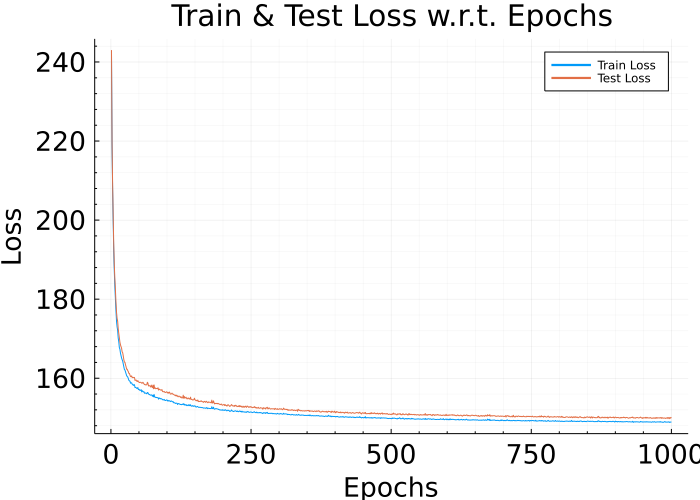

In [12]:
plot_loss_convergence(trn_loss_list[2:end], tst_loss_list[2:end], title = "Train & Test Loss w.r.t. Epochs")

In [13]:
theta = value.(Knet.load(joinpath(model_path,"Model_VAEGON2000.jld2"), )["model"][:decoder]);

In [14]:
function reparametrize(mu, logvar)
    
    std = exp.(0.5 .* logvar)
    epsilon = convert(atype, randn(F, size(mu)))
    z = mu .+ epsilon .* std
    
    return z
end

moments1 = bnmoments()
moments2 = bnmoments()
moments3 = bnmoments()

function decode(theta, z; batch_size = 64, training = true)
    
    mu = theta[1] * z .+ theta[2]
    logvar = theta[3] * z .+ theta[4]
    
    z = reparametrize(mu, logvar)
    
    z = reshape(z, (1, 1, nz, batch_size))
    z = deconv4(theta[5], z, mode = 1) .+ theta[6]
    z = mybatchnorm(z, moments1, theta[7]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[8], z, stride = 2, padding = 1, mode = 1) .+ theta[9]
    z = mybatchnorm(z, moments2, theta[10]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[11], z, stride = 2, padding = 1, mode = 1) .+ theta[12]
    z = mybatchnorm(z, moments3, theta[13]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[14], z, stride = 2, padding = 1, mode = 1) .+ theta[15]
    x_hat = Knet.sigm.(z)

    return x_hat, mu, logvar
end

function GONsample(theta, nz, batch_size; training = true)

    z = atype(randn(1,1, nz, batch_size))
    
    z = deconv4(theta[5], z, mode = 1) .+ theta[6]
    z = mybatchnorm(z, moments1, theta[7]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[8], z, stride = 2, padding = 1, mode = 1) .+ theta[9]
    z = mybatchnorm(z, moments2, theta[10]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[11], z, stride = 2, padding = 1, mode = 1) .+ theta[12]
    z = mybatchnorm(z, moments3, theta[13]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[14], z, stride = 2, padding = 1, mode = 1) .+ theta[15]
    x_hat = Knet.sigm.(z)

    return x_hat
end

function loss(theta, x, z)
    x_hat, mu, logvar = decode(theta, z)
    L = BCE(x, x_hat) + KLD(mu, logvar)
    return L
end

function decode_train(theta, x; batch_size = 64,training = true)
    origin = Param(atype(zeros(nz, batch_size)))

    derivative_origin = @diff loss(theta, x, origin)
    dz = grad(derivative_origin, origin)
    z = -dz
    x_hat, mu, logvar = decode(theta, z; training = training);
    return x_hat, mu, logvar
end

nz = 256
ngf = 16
batch_size = 64
# nc = 1 # nc : Number of channels is determined during dataset reading

# first batch of the test dataset
x_test_first = first(dtst);

nothing

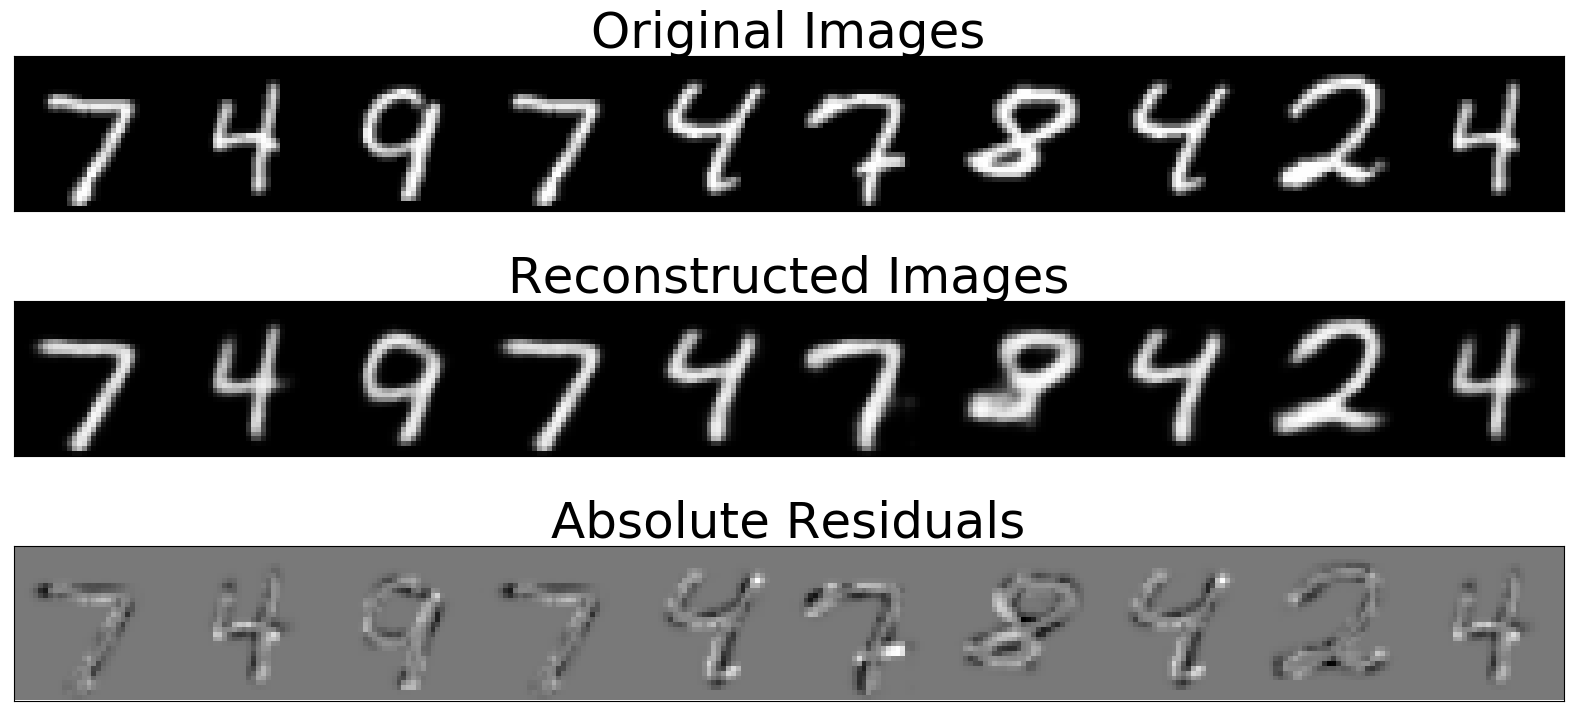

In [15]:
x = first(dtst);
x_hat, mu, logvar = decode_train(theta, x)
# plot_reconstructed_images(x_test_first, x_hat, 10, batch_size, (900,300))
x_hat_ = Array{Float32}(reshape(x_hat, 32,32,1,64))
x_ = Array{Float32}(reshape(x, 32,32,1,64))
display(plot_reconstructed_images_pyplot(x_, x_hat_; transpose_image = false))
figname = "mnist_Vgon_test_reconstructions_nz256"
plt.savefig(joinpath("Evaluation_Notebook", figname))

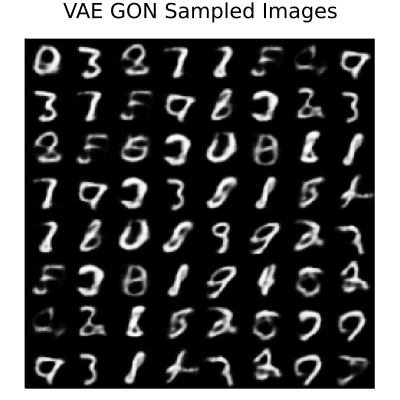

In [16]:
x_sampled = GONsample(theta, nz, 64)
display(plot_image_grid(x_sampled; grid_x_size = 8, grid_y_size = 8, title = "VAE GON Sampled Images"))
figname = "mnist_Vgon_sampled_nz256"
Plots.savefig(joinpath("Evaluation_Notebook", figname))

# VAE GON Fashion MNIST - NGF : 16, NZ : 256

In [17]:
use_saved_data = false
nc = nothing
dataset_name = "fashion"
if dataset_name == "mnist"
    nc = 1
    if use_saved_data
        xtrn = npzread("Data/MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))

    else

        xtrn,_ = MNIST.traindata()
        xtst,_ = MNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)
        
    end
    
elseif dataset_name == "fashion"
    nc = 1
    if use_saved_data

        xtrn = npzread("Data/Fashion_MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/Fashion_MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))
        
    else
        
        xtrn,_ = FashionMNIST.traindata()
        xtst,_ = FashionMNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)

    end
    
elseif dataset_name == "cifar"
    nc = 3
    xtrn,_= CIFAR10.traindata()
    xtst,_ = CIFAR10.testdata()
    xtrn = Array{Float64, 4}(xtrn)
    xtst = Array{Float64, 4}(xtst)
#     println("No implemented yet")
end

batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (32, 32, nc,:), xtype = atype, shuffle = true)
dtst = minibatch(xtst, batch_size; xsize = (32, 32, nc,:), xtype = atype);

In [18]:
results_path = "./Results/Variational_GON_ngf16_nz256_fashion1"
model_path = joinpath(results_path, "Saved_Models")

"./Results/Variational_GON_ngf16_nz256_fashion1/Saved_Models"

In [19]:
trn_loss_list = Knet.load(joinpath(results_path,"trn_loss_list.jld2"), )["trn_loss_list"]
tst_loss_list = Knet.load(joinpath(results_path,"tst_loss_list.jld2"), )["tst_loss_list"]
trn_rec_loss_list = Knet.load(joinpath(results_path,"trn_rec_loss_list.jld2"), )["trn_rec_loss_list"]
tst_rec_loss_list = Knet.load(joinpath(results_path,"tst_rec_loss_list.jld2"), )["tst_rec_loss_list"];

In [20]:
trn_loss_list[end], tst_loss_list[end], trn_rec_loss_list[end], tst_rec_loss_list[end]

(323.4902279323549, 326.1965114886944, 9.968376159667969, 10.178024291992188)

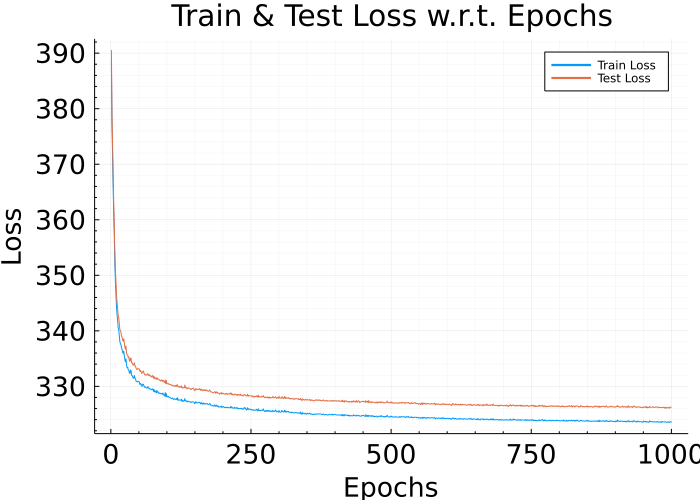

In [21]:
plot_loss_convergence(trn_loss_list[2:end], tst_loss_list[2:end], title = "Train & Test Loss w.r.t. Epochs")

In [22]:
theta = value.(Knet.load(joinpath(model_path,"Model_VAEGON2000.jld2"), )["model"][:decoder]);

nothing

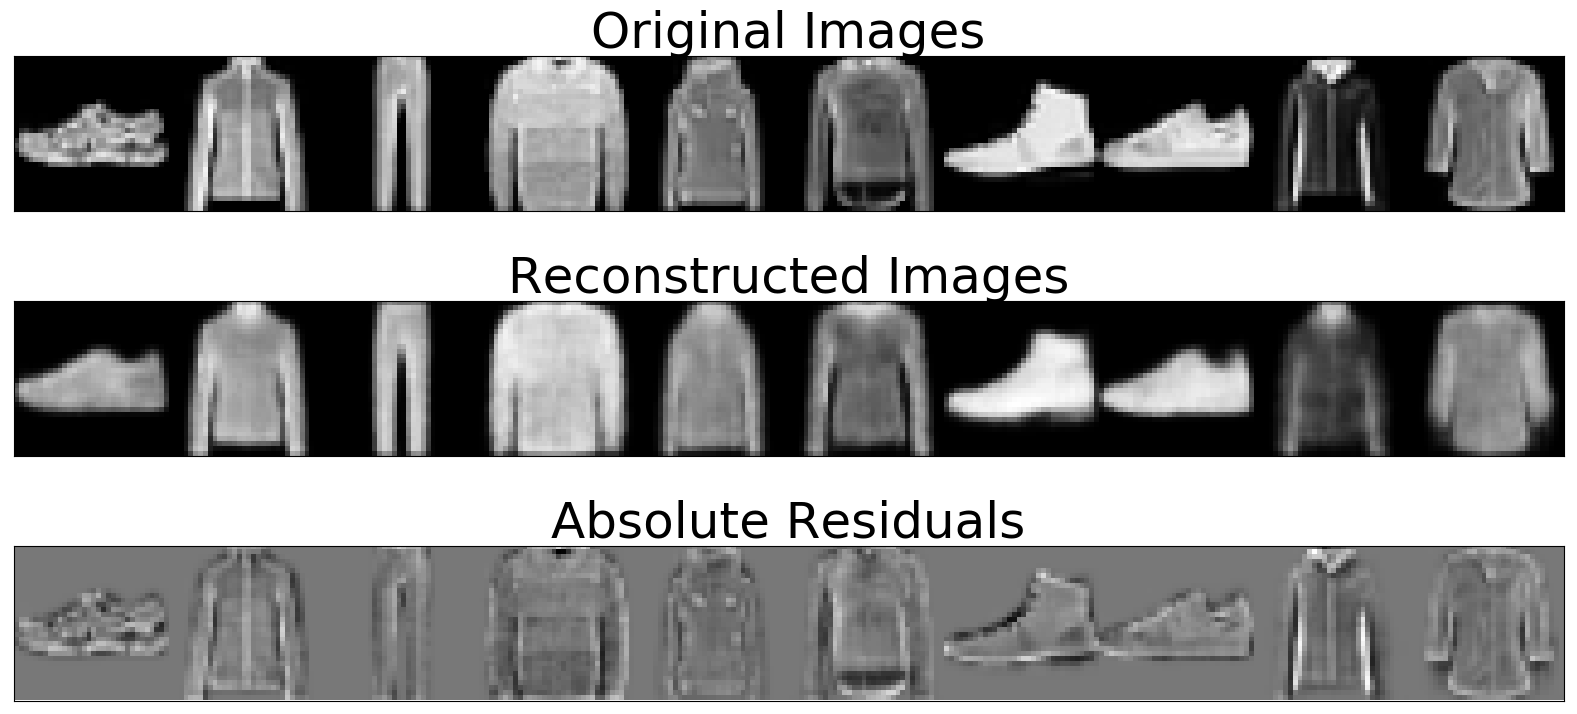

In [23]:
nz = 256
ngf = 16
batch_size = 64
# nc = 1 # nc : Number of channels is determined during dataset reading

# # first batch of the test dataset
# x_test_first = first(dtst);

# x_hat, mu, logvar = decode_train(theta, x_test_first)
# plot_reconstructed_images(x_test_first, x_hat, 10, batch_size, (900,300))
x = first(dtst);
x_hat, mu, logvar = decode_train(theta, x)
# plot_reconstructed_images(x_test_first, x_hat, 10, batch_size, (900,300))
x_hat_ = Array{Float32}(reshape(x_hat, 32,32,1,64))
x_ = Array{Float32}(reshape(x, 32,32,1,64))
display(plot_reconstructed_images_pyplot(x_, x_hat_; transpose_image = false))
figname = "fashion_Vgon_test_reconstructions_nz256"
plt.savefig(joinpath("Evaluation_Notebook", figname))

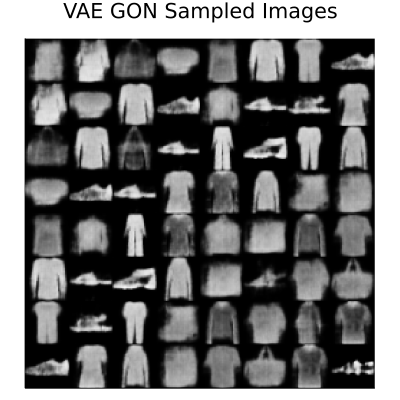

In [25]:
x_sampled = GONsample(theta, nz, 64)
display(plot_image_grid(x_sampled; grid_x_size = 8, grid_y_size = 8, title = "VAE GON Sampled Images"))
figname = "fashion_Vgon_sampled_nz256"
Plots.savefig(joinpath("Evaluation_Notebook", figname))